# MACE energy benckmark

## Setup

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io.trajectory import Trajectory
from scipy.stats import pearsonr, spearmanr
from pathlib import Path

## Plot styles

In [82]:
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

#### Predifined color palettes

In [83]:
palettes = {
    "ocean_sunset": {
        "scatter": "#4DBBD5",
        "trend": "#E64B35",
        "band": "#BFDDEB",
    },
    "slate_forest": {
        "scatter": "#3C5488",
        "trend": "#00A087",
        "band": "#C8D2EC",
    },
    "mist_coral": {
        "scatter": "#91D1C2",
        "trend": "#E64B35",
        "band": "#DFF2EF",
    },
    "clear_contrast": {
        "scatter": "#0072B2",
        "trend": "#D55E00",
        "band": "#A6CEE3",
    }
}

## Statistical functions

#### We compute rolling median to show robust trend and rolling IQR band (25-75%) to show distriburion

In [84]:
def prepare_rolling_array(a, win: int):
    a = np.asarray(a, dtype=float).ravel()

    if win < 3:
        raise ValueError("window must be >= 3.")

    if win % 2 == 0:
        raise ValueError("window must be odd.")

    pad = win // 2
    a_padded = np.pad(a, (pad, pad), mode="edge")

    return a_padded

def compute_rolling_median(a, win: int):
    a_padded = prepare_rolling_array(a, win)
    median_a = np.empty_like(a)

    for i in range(len(a)):
        median_a[i] = np.median(a_padded[i:i+win])

    return median_a

def compute_rolling_band(a, win: int):
    a_padded = prepare_rolling_array(a, win)
    lo_a = np.empty_like(a)
    hi_a = np.empty_like(a)

    for i in range(len(a)):
        lo_a[i] = np.quantile(a_padded[i:i+win], 0.25)
        hi_a[i] = np.quantile(a_padded[i:i+win], 0.75)

    return lo_a, hi_a

## Plotting

#### Input configuration

In [85]:
traj_file = "sub100_film100_termAs_P4-mmm_1_As_P4-mmm_1_cand0.traj"
score_key = "fgw_score"
energy_key = "mace_energy"
palette = "ocean_sunset"
window = 3

#### Load data from BO trajectory

In [86]:
traj = Trajectory(traj_file, "r")
scores = []
energies = []

for k, at in enumerate(traj):
    if score_key not in at.info:
        raise KeyError(f"Missing info['{score_key}'] in frame {k}.")
    if energy_key not in at.info:
        raise KeyError(f"Missing info['{energy_key}'] in frame {k}.")
    scores.append(float(at.info[score_key]))
    energies.append(float(at.info[energy_key]))

traj.close()

#### Compute correlations, rolling median and IQR band

In [87]:
scores = np.asarray(scores, dtype=float)
energies = np.asarray(energies, dtype=float)
mask = np.isfinite(scores) & np.isfinite(energies)
scores_clean = scores[mask]
energies_clean = energies[mask]
rho, p_spearman = spearmanr(scores_clean, energies_clean)
r, p_pearson = pearsonr(scores_clean, energies_clean)
idx = np.argsort(scores)
s_sorted = scores[idx]
e_sorted = energies[idx]
trend = compute_rolling_median(e_sorted, window)
lo, hi = compute_rolling_band(e_sorted, window)

#### Plot score vs energy with rolling median and IQR band

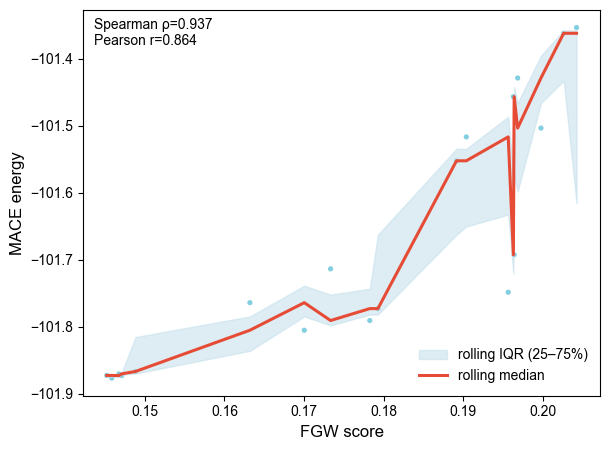

In [88]:
pal = palettes[palette]
fig, ax = plt.subplots(figsize=(6.2, 4.6))
ax.scatter(scores, energies, s=14, alpha=0.70, edgecolors="none", c=pal["scatter"])
ax.fill_between(s_sorted, lo, hi, alpha=0.50, label="rolling IQR (25–75%)", color=pal["band"])
ax.plot(s_sorted, trend, lw=2.2, label="rolling median", color=pal["trend"])
ax.set_xlabel(f"FGW score")
ax.set_ylabel(f"MACE energy")
txt = f"Spearman ρ={rho:.3f}\nPearson r={r:.3f}"
ax.text(0.02, 0.98, txt, transform=ax.transAxes, va="top", ha="left",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85, linewidth=0.0))
ax.legend(frameon=False)
plt.tight_layout()
fig.savefig(Path(traj_file).with_suffix(".pdf"), bbox_inches="tight")
plt.show()